### importing

In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import optuna
from sklearn.model_selection import cross_val_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

training_set_labels = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/training_set_labels.csv')
training_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/traning_set_values.csv')
test_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/test_set_values.csv')



train_data = pd.merge(training_set_values, training_set_labels, on='id')
train_df=train_data.copy()
test_df = test_set_values.copy()

### feaure engineering for population using KNN Imputer

In [ ]:
from sklearn.impute import KNNImputer
import numpy as np

# ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
# ['pay annually' 'never pay' 'pay per bucket' 'unknown' 'pay when scheme fails' 'other' 'pay monthly']
# ['communal standpipe' 'hand pump' 'other' 'improved spring' 'cattle trough' 'dam']


from sklearn.impute import KNNImputer
import numpy as np

def impute_population_knn(df, is_train=True, n_neighbors=5):
    df = df.copy()

    # Dictionaries inside function
    dict_population_train = {
        'quantity': ['enough', 'insufficient'],
        'payment': ['pay annually', 'pay per bucket', 'pay monthly'],
        'waterpoint_type_group': ['improvedspring'],
        'status_group': ['functional', 'functional needs repair'],
    }

    dict_population_test = {
        'quantity': ['enough', 'insufficient'],
        'payment': ['pay annually', 'pay per bucket', 'pay monthly'],
        'waterpoint_type_group': ['improvedspring'],
    }

    dict_population = dict_population_train if is_train else dict_population_test

    # Count original zeros
    total_zeros_before = (df['population'] == 0).sum()

    # Identify rows where population is zero
    zero_pop_mask = df['population'] == 0

    # Build mask for rows matching any dictionary criteria
    match_mask = np.zeros(len(df), dtype=bool)
    for col, values in dict_population.items():
        if col in df.columns:
            match_mask |= df[col].isin(values)

    # Target rows where population is zero and match criteria
    target_mask = zero_pop_mask & match_mask
    total_to_impute = target_mask.sum()

    if total_to_impute == 0:
        print(f"[INFO] No rows to impute. Population=0 count: {total_zeros_before}")
        return df

    # Prepare numeric columns excluding 'id' and 'population'
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'id' in numeric_cols:
        numeric_cols.remove('id')
    if 'population' in numeric_cols:
        numeric_cols.remove('population')

    # Prepare dataframe for KNNImputer
    df_knn = df[numeric_cols + ['population']].copy()
    df_knn.loc[target_mask, 'population'] = np.nan

    # Apply KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed = imputer.fit_transform(df_knn)

    # Update population with imputed values only for target rows
    imputed_population = np.round(imputed[:, -1]).astype(int)
    df.loc[target_mask, 'population'] = imputed_population[target_mask.values]

    # Count zeros after imputation
    total_zeros_after = (df['population'] == 0).sum()

    # Number of successful imputations
    total_imputed = total_to_impute - (df.loc[target_mask, 'population'] == 0).sum()

    print(f"[INFO] Original population=0 count: {total_zeros_before}")
    print(f"[INFO] Population=0 after imputation: {total_zeros_after}")
    print(f"[INFO] Total imputed population values: {total_imputed}")

    return df

# Usage example:
# df = impute_population_knn(df, is_train=True, n_neighbors=5)


In [ ]:
train_df=impute_population_knn(train_df, is_train=True, n_neighbors=5)

[INFO] Original population=0 count: 21381
[INFO] Population=0 after imputation: 19832
[INFO] Total imputed population values: 1549


In [23]:
test_df=impute_population_knn(test_df, is_train=False, n_neighbors=5)

[INFO] Original population=0 count: 5073
[INFO] Population=0 after imputation: 5066
[INFO] Total imputed population values: 7


### inputing construciton year when it is 0 (there are 20709, 43.9%)

In [ ]:
def impute_construction_year(df, construction_col='construction_year', n_neighbors=5):
    df = df.copy()

    # Treat 0 as missing
    df[construction_col] = df[construction_col].replace(0, np.nan)

    # Select only numeric columns for KNN
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if construction_col not in numeric_cols:
        raise ValueError(f"{construction_col} must be a numeric column")

    # Apply KNN Imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Round construction_year to nearest year and cast to int
    df[construction_col] = df[construction_col].round().astype(int)

    return df

In [ ]:
train_df = impute_construction_year(train_df, construction_col='construction_year', n_neighbors=5)
test_df = impute_construction_year(test_df, construction_col='construction_year', n_neighbors=5)

### making a column for the age of the water point

In [ ]:
def add_age_column(df, construction_col='construction_year', recorded_col='date_recorded', age_col='age'):
    df = df.copy()

    # Convert date_recorded to datetime
    df[recorded_col] = pd.to_datetime(df[recorded_col], errors='coerce')

    # Extract year from date_recorded
    recorded_year = df[recorded_col].dt.year

    # Calculate age = recorded_year - construction_year
    df[age_col] = recorded_year - df[construction_col]

    # Handle invalid/missing years
    df[age_col] = df[age_col].fillna(0).astype(int)
    df.loc[df[age_col] < 0, age_col] = 0  # If construction_year > recorded_year

    return df


In [ ]:
train_df= add_age_column(train_df, construction_col='construction_year', recorded_col='date_recorded', age_col='age')
test_df= add_age_column(test_df, construction_col='construction_year', recorded_col='date_recorded', age_col='age')



```
# This is formatted as code
```

### the code for random forest classifier with feature emgineered raininess score

In [ ]:
(train_df['num_private'] == 0).sum()

np.int64(58643)

In [ ]:
train_df['status_group'].value_counts()


,count
status_group,
functional,32259
non functional,22824
functional needs repair,4317


In [35]:
import pandas as pd
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


# Columns to drop, dropping num_private because 58643 out of 59400 column have value zero
# date recorede is changed becuase we feature engineered it to raininess score

duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by','num_private']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Function to assign raininess score by month
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Globals for label encoding
categorical_cols = []
encoders = {}

# 1. Preprocessing + Encoding (Label Encoding only)
def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    df = df.copy()

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                # Replace unseen categories with first known class
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# 2. Model Building

from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def build_model_label(train_df, data_proportion=1.0, n_estimators=550, max_depth=None,
                      random_state=42, balance=False, smote_multiplier=1,test_size=0.2):
    train_df = clean_encode_label(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    print("\n🔹 Class distribution BEFORE SMOTE:")
    for cls, count in Counter(y_train).items():
        print(f"  {cls}: {count}")

    if balance:
        smote = SMOTE(random_state=random_state)

        # Apply SMOTE once
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Repeat SMOTE if multiplier > 1
        if smote_multiplier > 1:
            for _ in range(smote_multiplier - 1):
                X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

        X_train, y_train = X_resampled, y_resampled

        print("\n SMOTE applied")
        print("🔹 Class distribution AFTER SMOTE:")
        for cls, count in Counter(y_train).items():
            print(f"  {cls}: {count}")
    else:
        print("\n SMOTE not applied. Using original training data.")

    # Train model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    # Evaluation
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n Trained on {len(X_train)} samples")
    print(f" Accuracy: {acc:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {'model': model}


# 3. Predict on Test Set
def predict_test_set_label(model_data, test_df):
    test_df_cleaned = clean_encode_label(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df


<ipython-input-26-052acec75bed>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)



🔹 Class distribution BEFORE SMOTE:
  functional: 25807
  non functional: 18259
  functional needs repair: 3454

 SMOTE applied
🔹 Class distribution AFTER SMOTE:
  functional: 25807
  non functional: 25807
  functional needs repair: 25807

 Trained on 77421 samples
 Accuracy: 0.8088

 Classification Report:
                         precision    recall  f1-score   support

             functional       0.82      0.88      0.85      6452
functional needs repair       0.49      0.34      0.40       863
         non functional       0.84      0.79      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.72      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



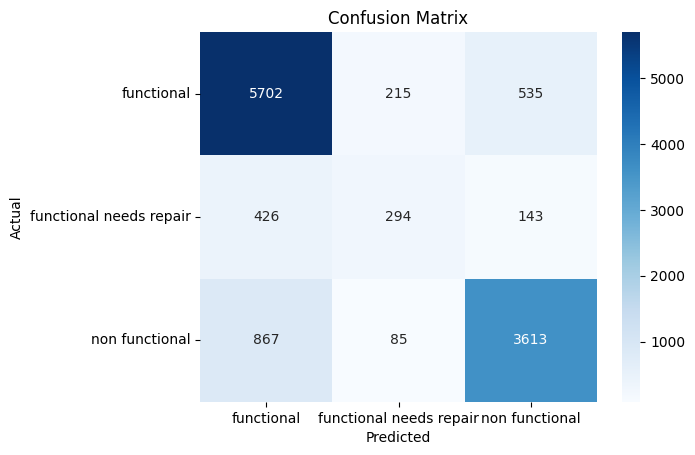

<ipython-input-26-052acec75bed>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)



🔹 Class distribution BEFORE SMOTE:
  functional: 25807
  non functional: 18259
  functional needs repair: 3454

 SMOTE not applied. Using original training data.

 Trained on 47520 samples
 Accuracy: 0.8125

 Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.55      0.31      0.40       863
         non functional       0.85      0.78      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



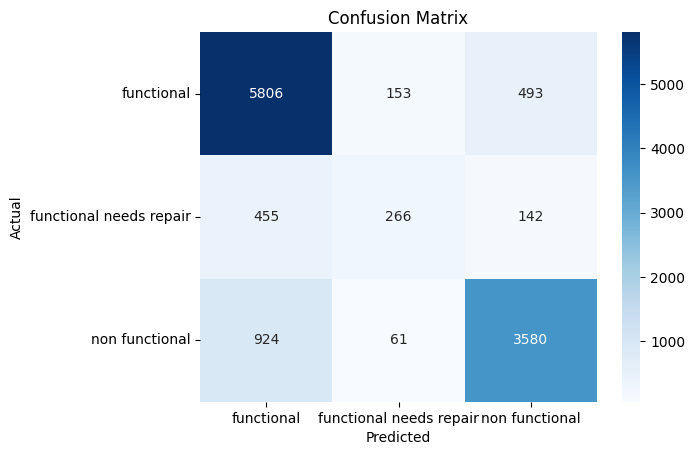

{'model': RandomForestClassifier(n_estimators=550, random_state=42)}

In [34]:
build_model_label(train_df, data_proportion=1, n_estimators=550, max_depth=None,
                      random_state=42, balance=True, smote_multiplier=1,test_size = 0.3)

build_model_label(train_df, data_proportion=1, n_estimators=550, max_depth=None,
                      random_state=42, balance=False, smote_multiplier=1, test_size = 0.3)